# File Processor (C3086)
## For use fits cubes made with quoka from gheald
### By Jack Livingston

In [1]:
#!/usr/bin/env python
import os,glob
import subprocess,shlex,shutil
import sys,getopt

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from math import *
import math
import glob
from numpy import unravel_index
import aplpy
from scipy.spatial.distance import pdist, squareform

/pkg/linux/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
def floater(textfile):
    """
    Turns text list of frequencies into array
    """
    data=[]
    info=np.asarray(textfile.split('\n'))
    for i in range(len(info)-1):
        data.append(float(info[i]))
    return np.asarray(data)

In [3]:
def aegeanparser(filename,cutoff=0):  
    '''
    Goes through aegean array and picks out the important things.
    
    input:
        filename = the aegean table's path
        cutoff = the number of items you want to include (from the top downwards) [default 0 or all].
    
    output: An array with the contents below, it is sorted based on col 5
        col 1,2 = RA + err
        col 3,4 = DEC + err
        col 5,6 = pol. intensity + err
        col 7,8 = a size + err
        col 9,10 = b size + err
        col 11 = position angle
    '''
    c=open(filename,'r').read().split('\n')
    my_data=np.zeros((len(c)-2,11))
    for i in range(2,len(c)-2): #skips titles 
        if len(open(filename,'r').read().split('\n')[i+2].split()[5:11])!=0: #ensure we aren't include blanks
            my_data[i]=np.concatenate((np.asarray(map(float,open(
                filename,'r').read().split('\n')[i+2].split()[5:11])),
            np.asarray(map(float,open(
                filename,'r').read().split('\n')[i+2].split()[13:18]))))
            k=i
    return my_data[my_data[:,4].argsort()][(len(c)-k):][-int(cutoff):]

In [4]:
def aegeanpositions(folder,aegean_path,cutoff):
    '''
    Uses aegeanparser and astropy wcs_world2pix to get the pixel coordinates of each stokes I peak within the image
    
    input:
        folder = the folder containing the fits image without the  final /
        aegean_path = the aegean table's path
        cutoff = the number of items you want to include (from the top downwards) [default 0 or all].
    
    output: An array with the following contents
        col 1,2 = x and y pixel coordinates
        col 3,4 = radius of ellipise in pixel coordinates
    
    '''
    f = fits.open(folder+'/'+folder.split('/')[-1]+'.i.single.fits')
    h = f[0].header
    w = WCS(h)
    ra,dec=aegeanparser(aegean_path,cutoff)[:,0],aegeanparser(aegean_path,cutoff)[:,2]
    
    rap=aegeanparser(aegean_path,cutoff)[:,0]+(aegeanparser(aegean_path,cutoff)[:,6])/(24*60)
    ram=aegeanparser(aegean_path,cutoff)[:,0]-(aegeanparser(aegean_path,cutoff)[:,6])/(24*60)
    
    decp=aegeanparser(aegean_path,cutoff)[:,2]+(aegeanparser(aegean_path,cutoff)[:,8])/(60*60)
    decm=aegeanparser(aegean_path,cutoff)[:,2]-(aegeanparser(aegean_path,cutoff)[:,8])/(60*60)
    
    return np.concatenate((np.asarray(w.wcs_world2pix(ra,dec,0,0,0))[0:2],
                       abs(np.asarray(w.wcs_world2pix(rap,decp,0,0,0))[0:2]-
                           np.asarray(w.wcs_world2pix(ram,decm,0,0,0))[0:2])/2))

In [5]:
def extrasource(folder,aegean_path,cutoff):
    """
    This function searches for peaks in Stokes I based on information from aegean source finder and uses that 
    information to extract the stokes info (freq,i,q,u,irms,qrms,urms) for all channels.
    
    input:
        folder = the folder containing the fits image without the  final /
        aegean_path = the aegean table's path
        cutoff = the number of items you want to include (from the top downwards) [default 0 or all].
    
    output: Two arrays come out
        Array 1: Position of Stokes I Peak in x any y pixel coordinates
        Array 2: Stokes Info
            col 1 = Frequency of the channel
            col 2,3,4 = Peak stokes i,q, and u data of mean 3x3 box around peak
            col 5,6,7 = RMS of stokes i,q, and u based on the standard dev. of a region of 75x75 pixels.
    """
    testi=fits.open(folder+'/'+folder.split('/')[-1]+'.i.smooth.fits')[0].data
    testq=fits.open(folder+'/'+folder.split('/')[-1]+'.q.smooth.fits')[0].data
    testu=fits.open(folder+'/'+folder.split('/')[-1]+'.u.smooth.fits')[0].data
    testv=fits.open(folder+'/'+folder.split('/')[-1]+'.v.smooth.fits')[0].data
    freqinfo=open(folder+'/'+folder.split('/')[-1]+'.i.frequencies.txt','r').read()
    check=np.nanmedian(abs(testq))
    c=len(testi)
    pixcor=aegeanpositions(folder,aegean_path,cutoff) #parses aegean table for peak positions
    d=pixcor.shape[1]
    data=np.zeros((d,c-1,7)) #freq,i,q,u,irms,qrms,urms
    position=np.zeros((d,c-1,2))
    for j in range(d):
        for i in range(c-1):
            x=(unravel_index(testi[i+1][int(pixcor[:,j][1]-pixcor[:,j][3]):int(pixcor[:,j][1]+pixcor[:,j][3]),
                int(pixcor[:,j][0]-pixcor[:,j][2]):int(pixcor[:,j][0]+pixcor[:,j][2])].argmax(), 
                testi[i+1][int(pixcor[:,j][1]-pixcor[:,j][3]):int(pixcor[:,j][1]+pixcor[:,j][3]),
                int(pixcor[:,j][0]-pixcor[:,j][2]):int(pixcor[:,j][0]+pixcor[:,j][2])].shape
                            )[0]+(int(pixcor[:,j][1]-pixcor[:,j][3]))) #gets the x position of peak
            
            y=(unravel_index(testi[i+1][int(pixcor[:,j][1]-pixcor[:,j][3]):int(pixcor[:,j][1]+pixcor[:,j][3]),
                int(pixcor[:,j][0]-pixcor[:,j][2]):int(pixcor[:,j][0]+pixcor[:,j][2])].argmax(), 
                testi[i+1][int(pixcor[:,j][1]-pixcor[:,j][3]):int(pixcor[:,j][1]+pixcor[:,j][3]),
                int(pixcor[:,j][0]-pixcor[:,j][2]):int(pixcor[:,j][0]+pixcor[:,j][2])].shape
                            )[1]+(int(pixcor[:,j][0]-pixcor[:,j][2]))) #gets the y position of peak
            if abs(testq[i][x,y])<check*75: #checks if the channel is RFI (not a smart filter)
                data[j,i,0]=floater(freqinfo)[i+1] #collects freq info
                data[j,i,1]=np.nanmean(testi[i+1][x-1:x+1,y-1:y+1]) #collects stokes i
                data[j,i,2]=np.nanmean(testq[i+1][x-1:x+1,y-1:y+1]) #collects stokes q
                data[j,i,3]=np.nanmean(testu[i+1][x-1:x+1,y-1:y+1]) #collects stokes u
                data[j,i,4]=np.nanstd(testv[i+1][x-20:x+20,y-20:y+20])*np.sqrt(2) #collects stokes i rms
                data[j,i,5]=np.nanstd(testv[i+1][x-20:x+20,y-20:y+20]) #collects stokes q rms
                data[j,i,6]=np.nanstd(testv[i+1][x-20:x+20,y-20:y+20]) #collects stokes u rms
                position[j,i,0]=x #records the x position of peak
                position[j,i,1]=y #records the y position of peak
    return (np.median(np.asarray(position),axis=1)),data

In [6]:
def datasaver(folder,aegaen_path,cutoff,out):
    '''
    Saves data into a text file that is space delimited for use with RMsynth and RMclean pipelines
    
    input:
        folder = the folder containing the fits image without the  final /
        aegean_path = the aegean table's path
        cutoff = the number of items you want to include (from the top downwards) [default 0 or all].
        out = output folder
        
    output: text file with name of source_pixelx_pixely.dat 
    '''
    loadin=extrasource(folder,aegaen_path,cutoff)
    data=loadin[1]
    d=data.shape[0]
    name=loadin[0]
    source=folder.split('/')[-1].split('-')[0]+'_'+folder.split('/')[-1].split('-')[1]
    for i in range(d):
        if name[i][1] < 1000: # ensures all pixel coordinates are of format ####
            if name[i][0] < 1000:
                np.savetxt(out+ 
                 source +'_0'+ str(int(name[i][0]))+'_0'
                           +str(int(name[i][1])) + ".dat" ,data[i],delimiter=' ')
            else:
                np.savetxt(out+ 
                 source +'_'+ str(int(name[i][0]))+'_0'
                           +str(int(name[i][1])) + ".dat" ,data[i],delimiter=' ')
        elif name[i][0] < 1000: # ensures all pixel coordinates are of format ####
            np.savetxt(out+ 
                source +'_0'+ str(int(name[i][0]))+'_'
                        +str(int(name[i][1])) + ".dat" ,data[i],delimiter=' ')
        else:
            np.savetxt(out+ 
                source +'_'+ str(int(name[i][0]))+'_'
                       +str(int(name[i][1])) + ".dat" ,data[i],delimiter=' ')

In [7]:
# 2016-04-22
aegeanpath2016_04_22='/priv/myrtle2/possum/livingston/C3086/2016-04-22/0517-718/aegean_table'
image2016_04_22='/priv/myrtle2/possum/livingston/C3086/2016-04-22/0517-718'

In [9]:
# 2016-04-23
aegeanpath2016_04_23='/priv/myrtle2/possum/livingston/C3086/2016-04-23/0525-674/aegean_table'
image2016_04_23='/priv/myrtle2/possum/livingston/C3086/2016-04-23/0525-674'

In [10]:
# 2016-04-24
aegeanpath2016_04_24='/priv/myrtle2/possum/livingston/C3086/2016-04-24/0439-6722/aegean_table'
image2016_04_24='/priv/myrtle2/possum/livingston/C3086/2016-04-24/0439-6722'

In [20]:
datasaver(image2016_04_22,aegeanpath2016_04_22,11,image2016_04_22+'/stokesinfo/')

/pkg/linux/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/pkg/linux/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice
/pkg/linux/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice


___
## TESTING FUNCTIONS

In [8]:
ra,dec=aegeanparser(aegeanpath2016_04_22,11)[:,0],aegeanparser(aegeanpath2016_04_22,11)[:,2]

In [9]:
f = aplpy.FITSFigure(image2016_04_22+'/'+image2016_04_22.split('/')[-1]+'.i.single.fits',dimensions=[0,1],slices=[0]);
f.show_grid();
f.show_colorscale(cmap='plasma',vmin=-0.005,vmax=0.005);
f.add_colorbar()
f.show_markers(ra,dec, layer='marker2', edgecolor='black',facecolor='blue', marker='o',alpha='0.2',s=100)

IOError: File not found: /priv/myrtle2/possum/livingston/C3086/2016-04-22/0517-718/0517-718.i.single.fits

In [14]:
data0517_718=extrasource(image2016_04_23,aegeanpath2016_04_23,11)

/pkg/linux/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/pkg/linux/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice
/pkg/linux/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice


In [42]:
data0517_718[0]

array([[ 563.,  734.],
       [1679.,  560.],
       [ 684., 1228.],
       [ 562.,  301.],
       [1242., 1898.],
       [1395., 1089.],
       [1720., 1271.],
       [1472.,  595.],
       [1472.,  595.],
       [ 618., 1342.],
       [1000.,  999.]])

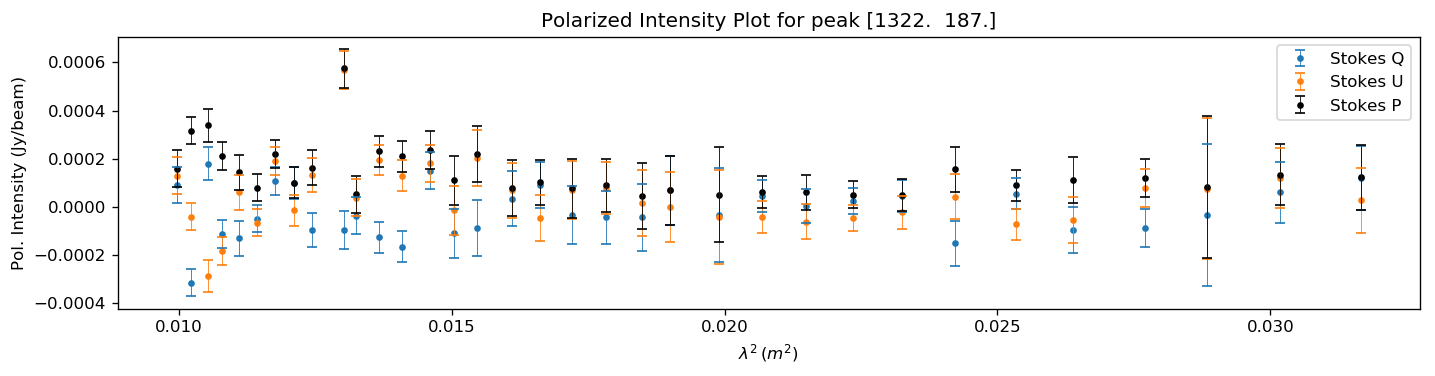

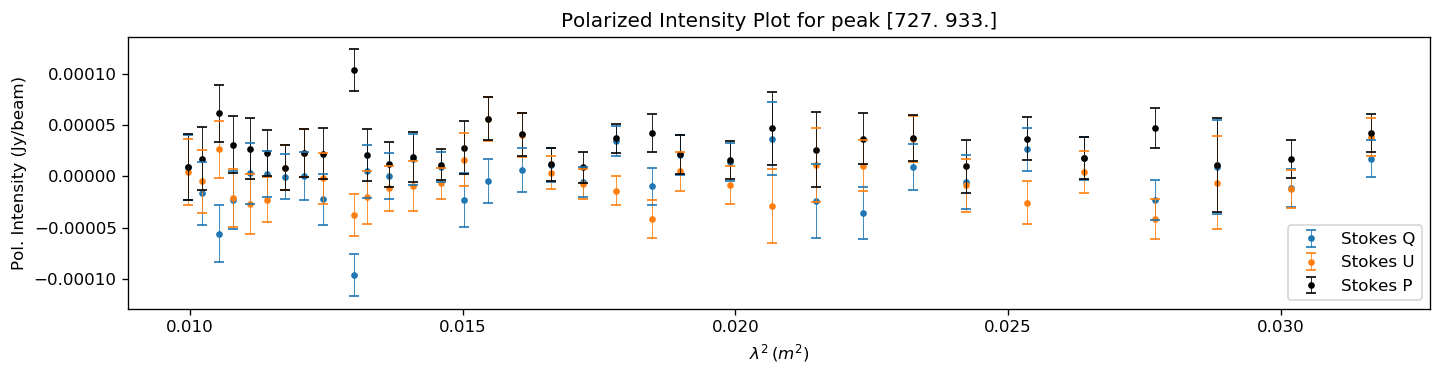

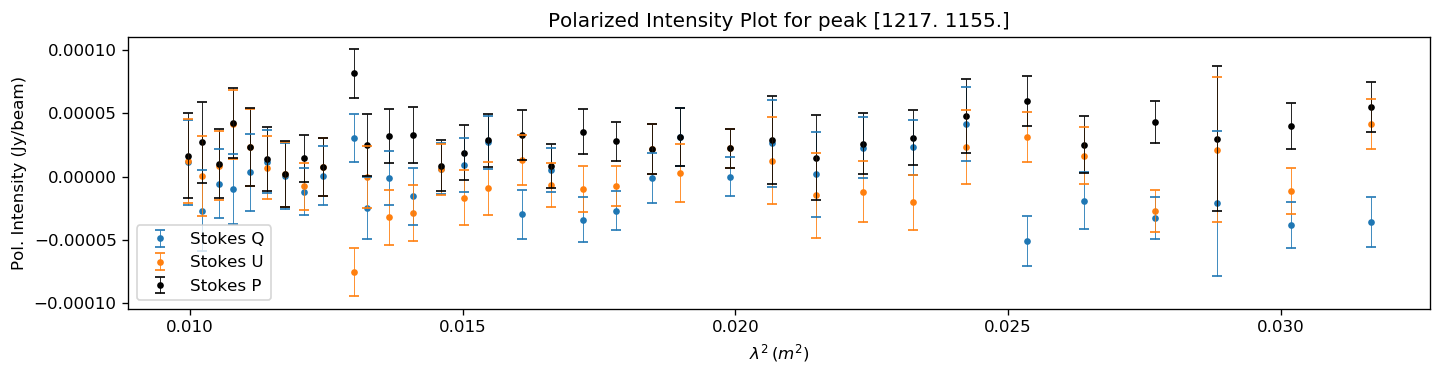

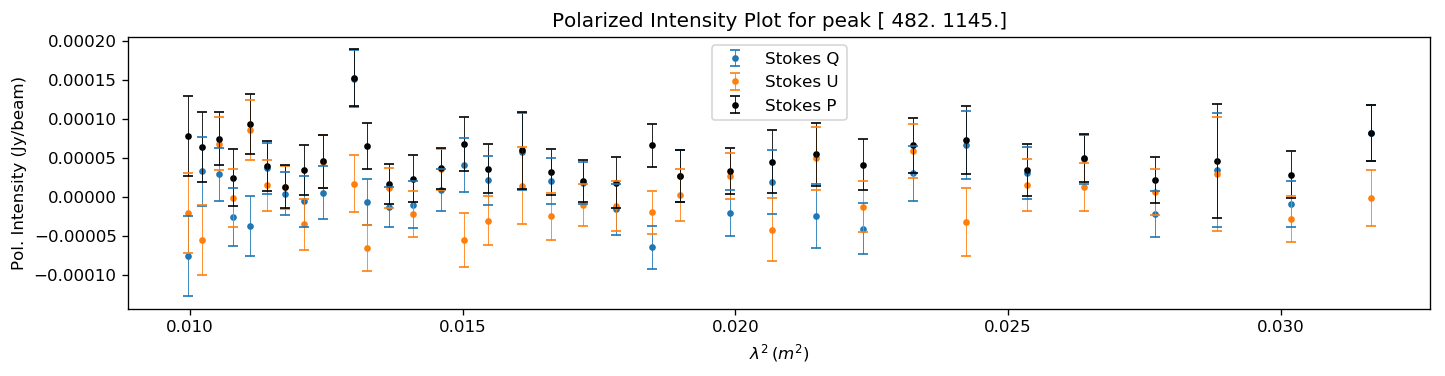

/pkg/linux/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in divide
  after removing the cwd from sys.path.
/pkg/linux/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in divide
  
/pkg/linux/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in divide
  


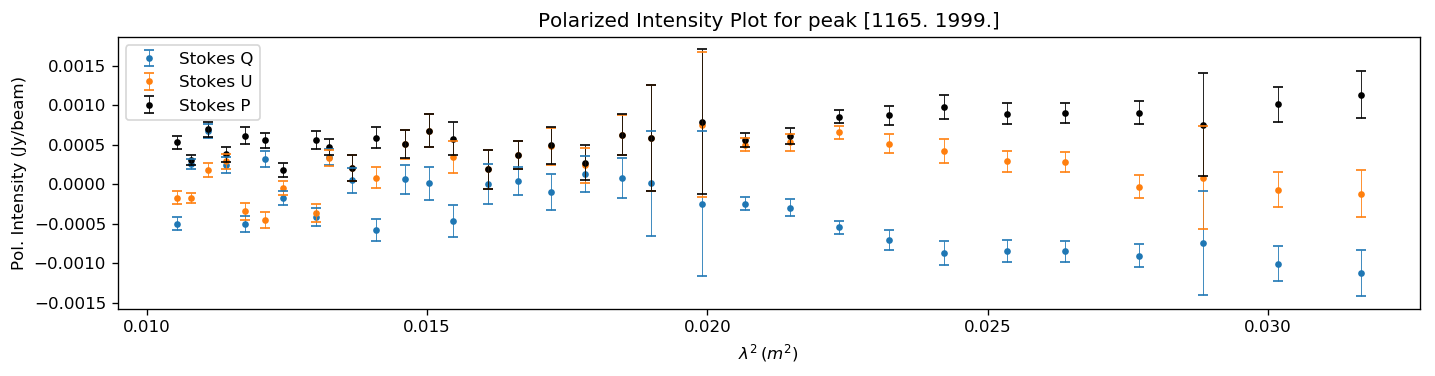

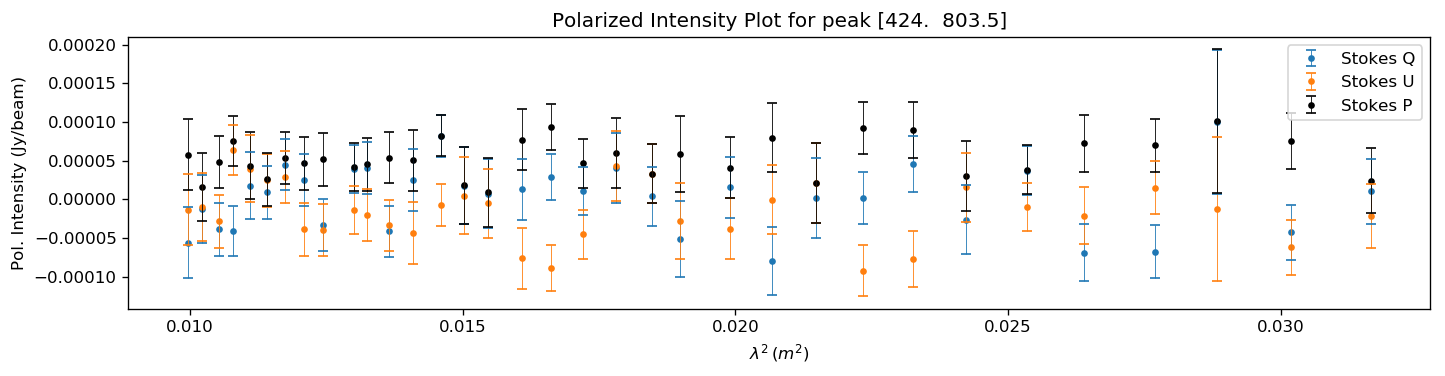

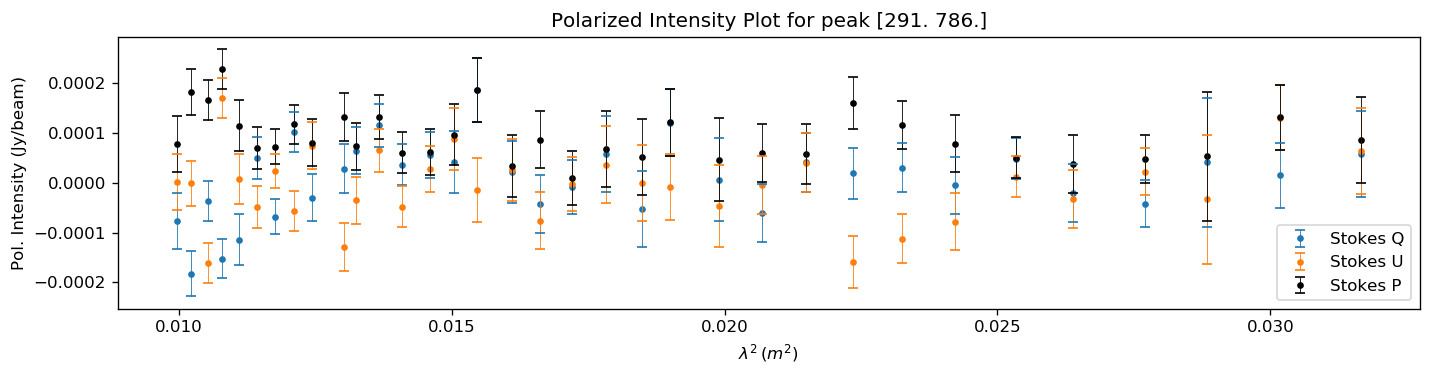

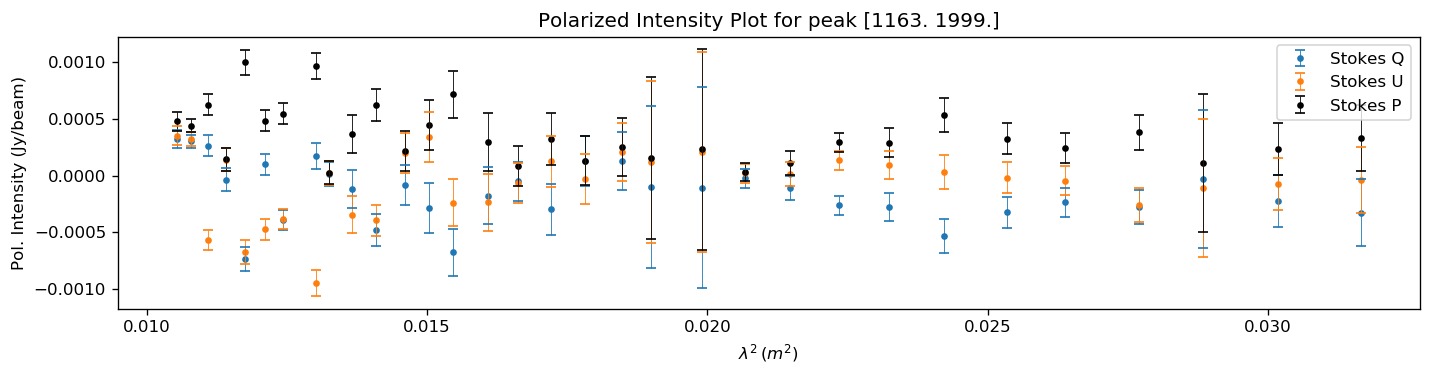

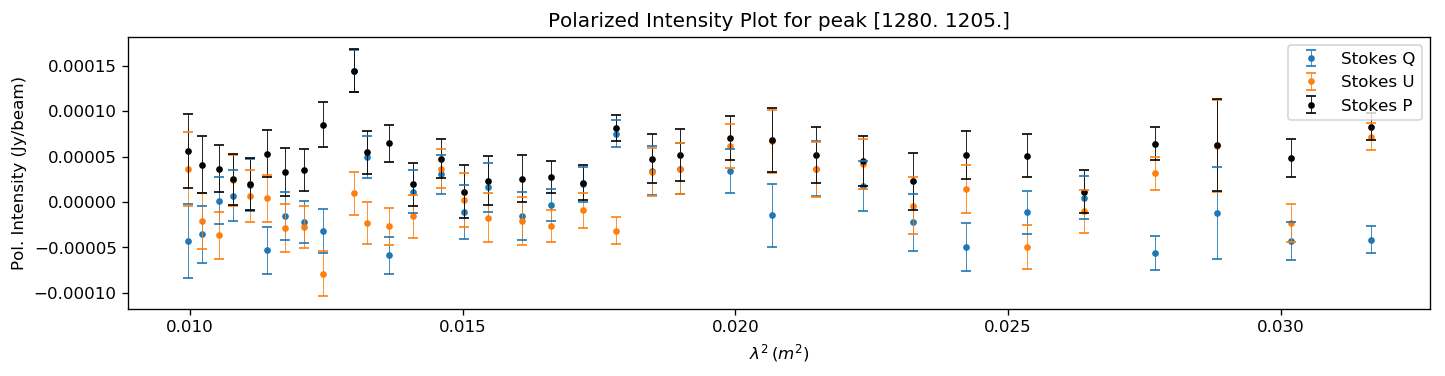

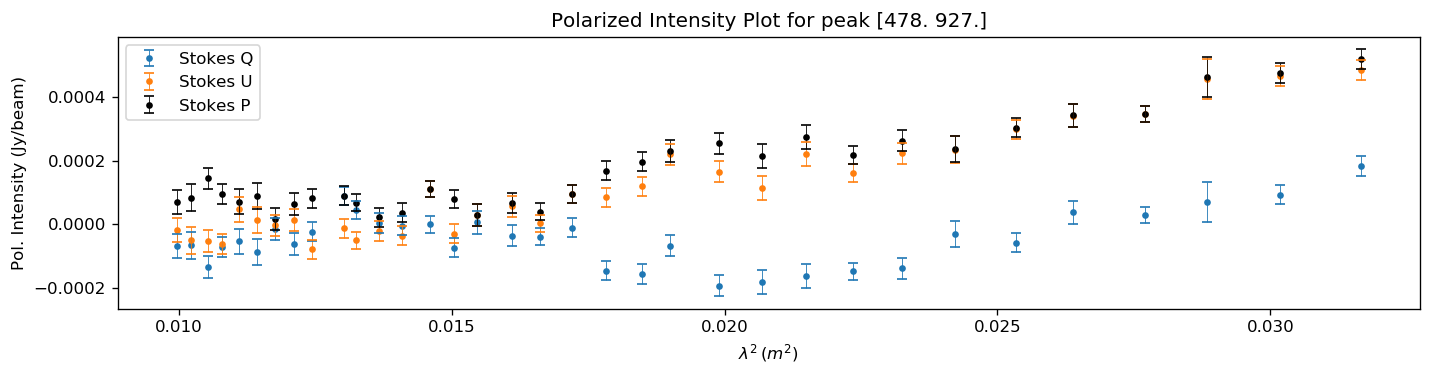

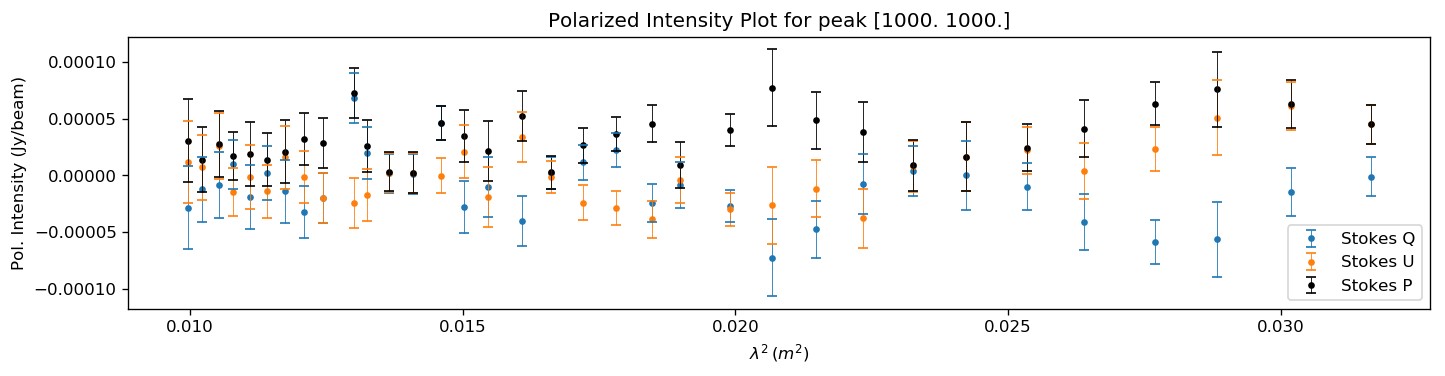

In [15]:
for i in range(len(data0517_718[1])):
    name=str(data0517_718[0][i])
    plt.figure(figsize=(14, 3), dpi=120)
    plt.errorbar((299792458/data0517_718[1][i][:,0])**2,data0517_718[1][i][:,2],yerr=data0517_718[1][i][:,5],
             color='C0',elinewidth=0.5,ecolor='C0',capsize=3,barsabove=True,label="Stokes Q",fmt='.')
    plt.errorbar((299792458/data0517_718[1][i][:,0])**2,data0517_718[1][i][:,3],yerr=data0517_718[1][i][:,6],
             color='C1',elinewidth=0.5,ecolor='C1',capsize=3,barsabove=True,label="Stokes U",fmt='.')
    plt.errorbar((299792458/data0517_718[1][i][:,0])**2,
             (data0517_718[1][i][:,2]**2+data0517_718[1][i][:,3]**2)**0.5,yerr=data0517_718[1][i][:,6],
             color='k',elinewidth=0.5,ecolor='k',capsize=3,barsabove=True,label="Stokes P",fmt='.')
    plt.xlabel(r'$\lambda^2\,(m^{2})$')
    plt.ylabel(r'Pol. Intensity (Jy/beam)')
    plt.legend()
    plt.title('Polarized Intensity Plot for peak ' + name)
    plt.show()